In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec
import itertools
import operator
import numpy as np
import math
%matplotlib inline 
plt.ion()
#plt.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

plt.rcParams['axes.titlesize'] = 22



from time import time
import datetime

import sys
sys.path.append('../simulations/')
from grid_manager import *
from habitat_analysis import *
from hdf5_reader import *

## Landscape simulation function:

In [2]:
def perm_wall_sim(grid_shape = [30,60], Q=1, A=0.5, ww=3, wp=0.5, cw=[3,3], cp=[0.35,0.7]):
    # 1. initialize landscape
    n_rows,n_cols = grid_shape
    N = n_rows*n_cols
    qualities = np.ones((N,))*Q
    g = Grid(shape=grid_shape, qualities=qualities, nhood_size=8)
    g.A = A * g.A
    
    # 2. compute the wall
    wpt = int(math.floor(n_cols*wp)-math.ceil(ww/2))
    xs = range(wpt, wpt+ww)
     
    # 3. compute the corridors
    for i in range(len(cw)):
        cpt=int(math.floor(n_rows*cp[i])-math.floor(cw[i]/2.0))
        if i == 0:
            ys = range(cpt)
        else:
            ys=ys+range(max(ys)+1+cw[i-1], cpt)
    ys=ys+range(max(ys)+1+cw[i], n_rows)
    impossible_nodes = list(itertools.product(ys,xs))
    g.set_impossible_nodes(impossible_nodes, impossible_affinity=0.0)
    return g

# check the extreme examples


In [3]:
#affinity = 1.
affinity = 0.37
ia = 0. # IMPOSSIBLE AFFINITY
Q = 1.

lgs = []
lgs.append(perm_wall_sim(grid_shape = (55,41), Q=Q, A=affinity, ww=5, wp=0.5, cw=[3],  cp=[0.75]))
lgs.append(perm_wall_sim(grid_shape = (55,41), Q=Q, A=affinity, ww=5, wp=0.5, cw=[9],  cp=[0.81]))
lgs.append(perm_wall_sim(grid_shape = (55,41), Q=Q, A=affinity, ww=5, wp=0.5, cw=[15], cp=[0.87]))
# lgs.append(perm_wall_sim(grid_shape = [30,60], Q=Q, A=affinity, ww=5, wp=0.5, cw=[7,0], cp=[0.5,0.7])[0])
# lgs.append(perm_wall_sim(grid_shape = (31,61), Q=Q, A=affinity, ww=5, wp=0.5, cw=[0,0], cp=[0.5,0.7], ia=ia))


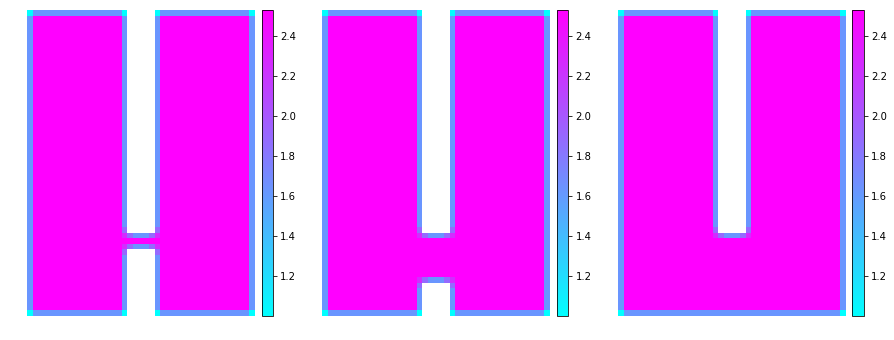

In [4]:
fig,axs = plt.subplots(1,3,figsize=(15,20))
lgs[0].plot_indegrees(ax = axs[0])
lgs[1].plot_indegrees(ax = axs[1])
lgs[2].plot_indegrees(ax = axs[2])

In [5]:
betas = [np.inf, 1., 0.1, 1e-2, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 0]

betas = [betas[i] for i in [0,1,6,8,11]]

In [6]:

distances = {}
all_HFs = {}
res = np.zeros((len(lgs),len(betas)))

for lg_i, G in enumerate(lgs):
    distances[lg_i] = {}
    for j,beta in enumerate(betas):
        print "Beta " + str(j+1) + "/" + str(len(betas))
        RSP = HabitatAnalysis(G, \
                              beta = beta, \
                              symmetric = False, \
                              similarity_measure='RSP_dissimilarity', \
                              affinity_to_cost='minus_log', \
                              distance_to_similarity='exp_minus', \
                              verbose=False)
        RSP.compute_similarities()

        #
        # SAVE DISTANCE MATRIX FROM EACH RUN:
        #
        distances[lg_i][j] = RSP.distances_all2L.copy()


Beta 1/5
Beta 2/5
Beta 3/5
Beta 4/5
Beta 5/5
Beta 1/5
Beta 2/5
Beta 3/5
Beta 4/5
Beta 5/5
Beta 1/5
Beta 2/5
Beta 3/5
Beta 4/5
Beta 5/5


In [7]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

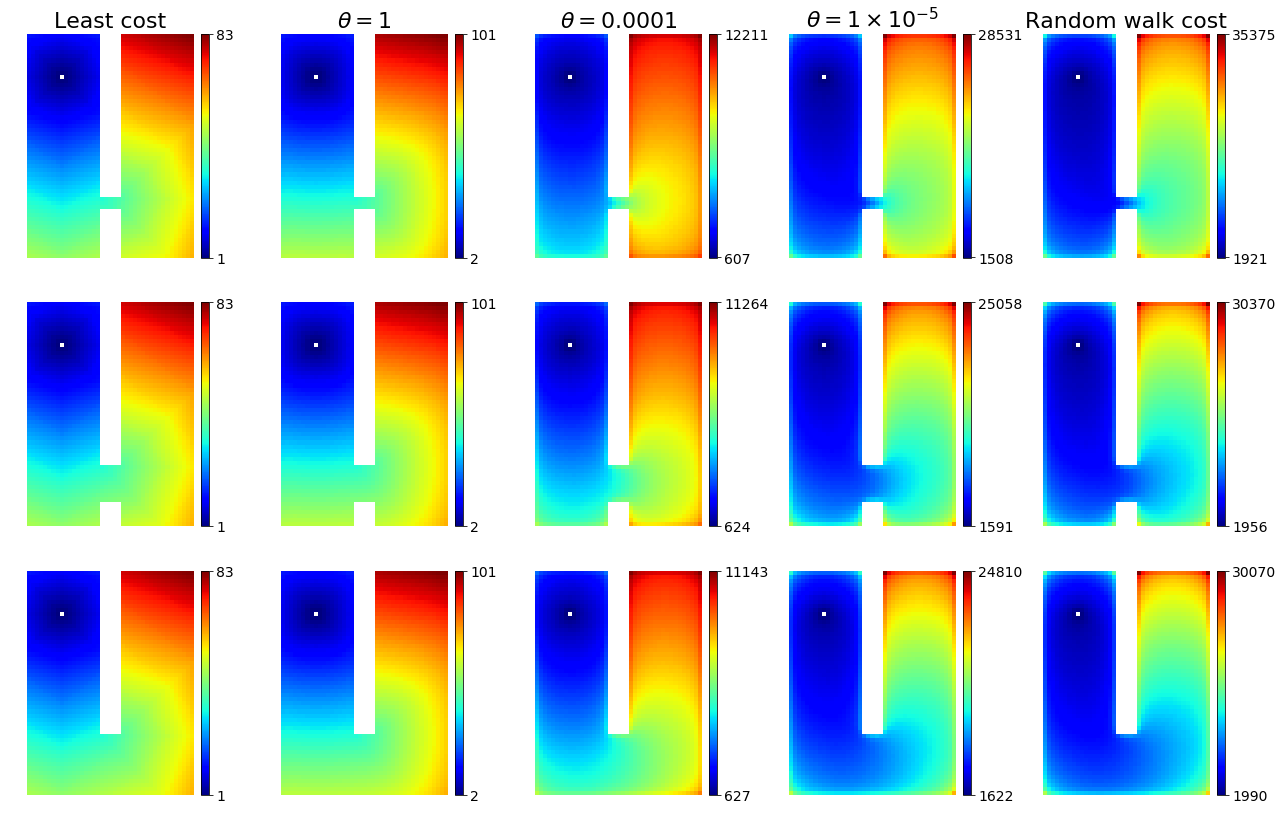

In [11]:
betas_plot = np.array(betas)# [[0,1,6,9,11]]

#betas_plot = [str(b) for b in betas_plot]
#betas_plot[0] = "\infty"
fig,axs = plt.subplots(len(lgs), len(betas_plot), figsize=(22,14))
for j,beta in enumerate(betas_plot):
    if j == 0:
        title_str = "Least cost"
    elif beta == betas[-1]:
        title_str = "Random walk cost"
    else:
        title_str = r"$\theta = " + latex_float(beta) + "$"
    for lg_i, G in enumerate(lgs):
        D = distances[lg_i][j]
        s_coord = (10,8) # the focus point of distances
        s = G.grid_coordinates_to_node_id(s_coord)
        Ds = D[s,:]
        
#        if lg_i == 0:
#            maxD = np.max(Ds)

        maxD = np.max(Ds)
        minD = np.min(Ds[np.arange(len(Ds)) != s])
        img, ax, cb = G.plot(Ds, ax = axs[lg_i,j], \
                             # source=s_coord, \
                             # vmin=0, vmax=maxD, \
                             colormap='jet')
#        if lg_i < 2:
#            cb.remove()
#        else:                
        cb.ax.tick_params(labelsize=14)
        cb.set_ticks([1.01*minD, maxD])
        cb.set_ticklabels([str(int(np.ceil(minD))), str(int(np.floor(maxD)))])
        
        if lg_i == 0:
            ax.set_title(title_str)
        

In [12]:
fig.savefig("corridor_distances.pdf", bbox_inches='tight')